## Imports & functions definition

In [1]:
repo_path <- ".."

In [2]:
# Required packages
library("data.table")
library("DALEX")
library("DALEXtra")
library("ggplot2")
library("gridExtra")
library("pipeR")

# Jupyter settings
options(repr.plot.width = 22)
options(repr.plot.height = 8)
options(jupyter.rich_display = FALSE)
options(width = 120)

# Paths within the repo
data_path <- file.path(repo_path, "data/survival-data-split")
model_path <- file.path(repo_path, "models/pickles/opt_XGBTRegressor.pickle")

Welcome to DALEX (version: 1.2.0).
Find examples and detailed introduction at: https://pbiecek.github.io/ema/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



In [3]:
# Function reads split data into a list.
read_data <- function(data_dir, extract_treatment = FALSE, ...) {
    data_names <- c("X_test", "X_train","y_test", "y_train")
    file_names <- sprintf("survival_%s.csv", data_names)
    paths <- file.path(data_dir, file_names)
    
    res <- setNames(lapply(paths, fread), data_names)
    if (!extract_treatment) return(res)
    
    extract_treatment(res, ...)
}


# Function separates treatment from the Xes.
extract_treatment <- function(data, idx = ncol(data$X_train)) {
    data <- lapply(data, as.data.frame)
    
    data$treatment_train <- data$X_train[, idx]
    data$X_train <- data$X_train[, -idx]
    
    data$treatment_test <- data$X_test[, idx]
    data$X_test <- data$X_test[, -idx]
    
    lapply(data, as.data.table)
}


# Function adjusts font size and fixes plot title for the DALEX plots to look cleanly in Jupyter Notebook.
fix_plot <- function(g, adjust_title_margin = FALSE, plot_title = NULL, font_size = 20) {
    g <- g + theme(
        axis.text = element_text(size = font_size),
        axis.title = element_text(size = font_size + 3),
        strip.text = element_text(size = font_size - 3, margin = margin(0, 0, 5, 0)),
        plot.subtitle = element_text(size = font_size - 2, margin = margin(-10, 0, 15, 0)),
        plot.title = element_text(size = font_size + 1),
        legend.title = element_text(size = font_size - 3),
        legend.text = element_text(size = font_size - 5)
    )
    
    if (adjust_title_margin) {
        g <- g + theme(plot.subtitle = element_text(margin = margin(0, 0, 5, 0)))
    }
    
    if (!is.null(plot_title)) {
        g <- g + ggtitle(plot_title)
    }
    
    g
}

## Reading the data

In [4]:
data <- read_data(data_path, TRUE)
X <- list(data$X_train, data$X_test) %>>% rbindlist() %>>% as.data.frame()
y <- list(data$y_train, data$y_test) %>>% rbindlist() %>>% as.data.frame()

## Creating explainers (one for each treatment variant)

In [5]:
explainer_Lev <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev",
    predict_function = function(model, data, ...) yhat(model, data)[, 1],
    verbose = FALSE
)

explainer_Lev5FU <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev+5FU",
    predict_function = function(model, data, ...) yhat(model, data)[, 2],
    verbose = FALSE
)

## Selecting observations for explainations

In [6]:
new_obs1 <- X[349, ]
new_obs1

    sex age obstruct perfor adhere nodes status differ extent surg node4
349 1   56  0        0      0      4     0      2      3      0    0    

In [7]:
new_obs2 <- X[634, ]
new_obs2

    sex age obstruct perfor adhere nodes status differ extent surg node4
634 0   68  0        0      1      2     1      1      3      0    0    

### Calculating variable attribution for selected observations

In [8]:
va_obs1_Lev <- variable_attribution(explainer_Lev, new_obs1, type = "shap")
va_obs1_Lev5FU <- variable_attribution(explainer_Lev5FU, new_obs1, type = "shap")

In [9]:
va_obs2_Lev <- variable_attribution(explainer_Lev, new_obs2, type = "shap")
va_obs2_Lev5FU <- variable_attribution(explainer_Lev5FU, new_obs2, type = "shap")

## SHAP plots with variable attribution

In [10]:
plot_va <- function(va1, va2) {
    p1 <- va1 %>>% plot() %>>% fix_plot(adjust_title_margin = TRUE)
    p2 <- va2 %>>% plot() %>>% fix_plot(adjust_title_margin = TRUE)
    
    grid.arrange(p1, p2, ncol = 2)
}

### Observation 1

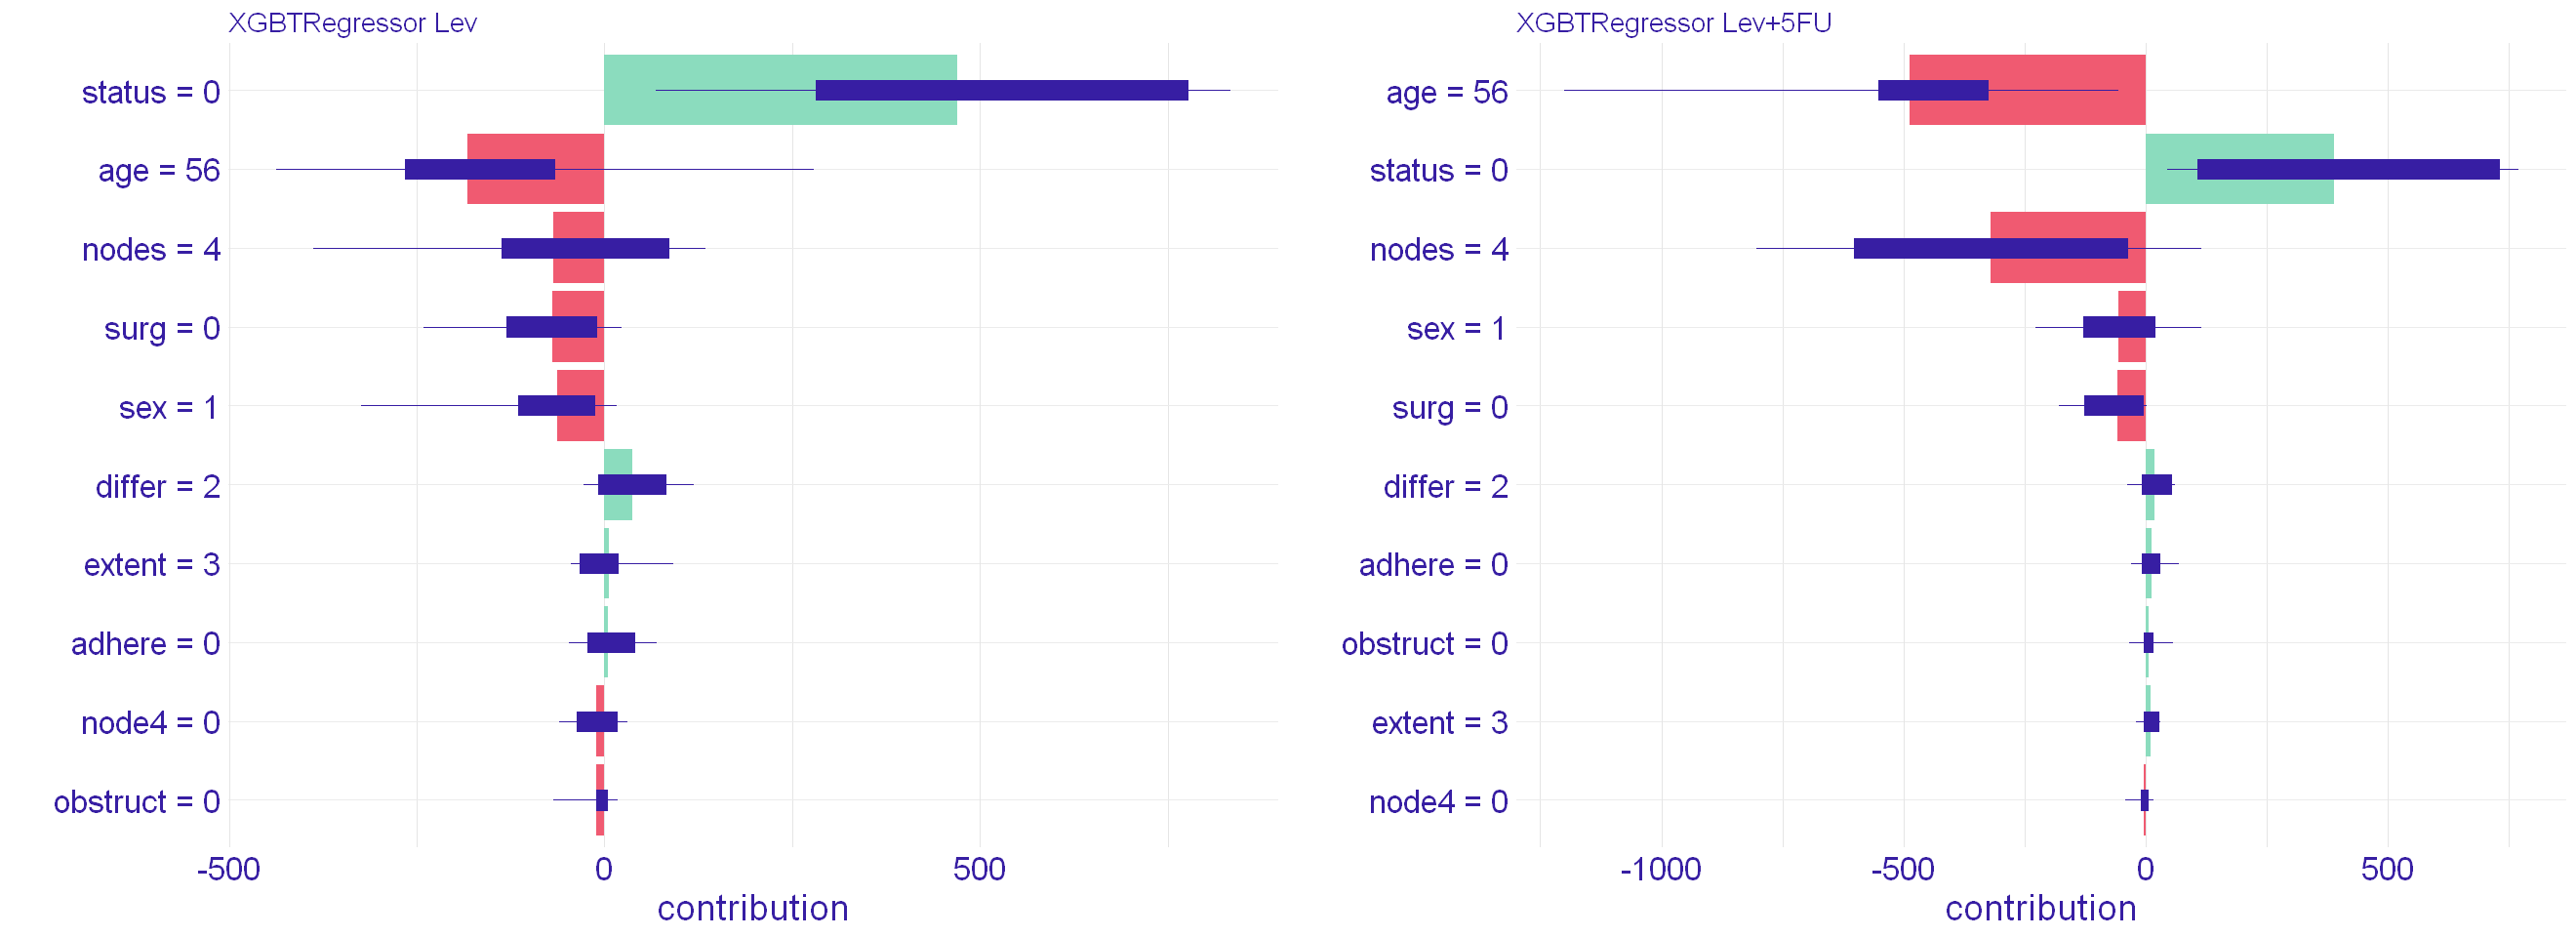

In [11]:
plot_va(va_obs1_Lev, va_obs1_Lev5FU)

### Observation 2

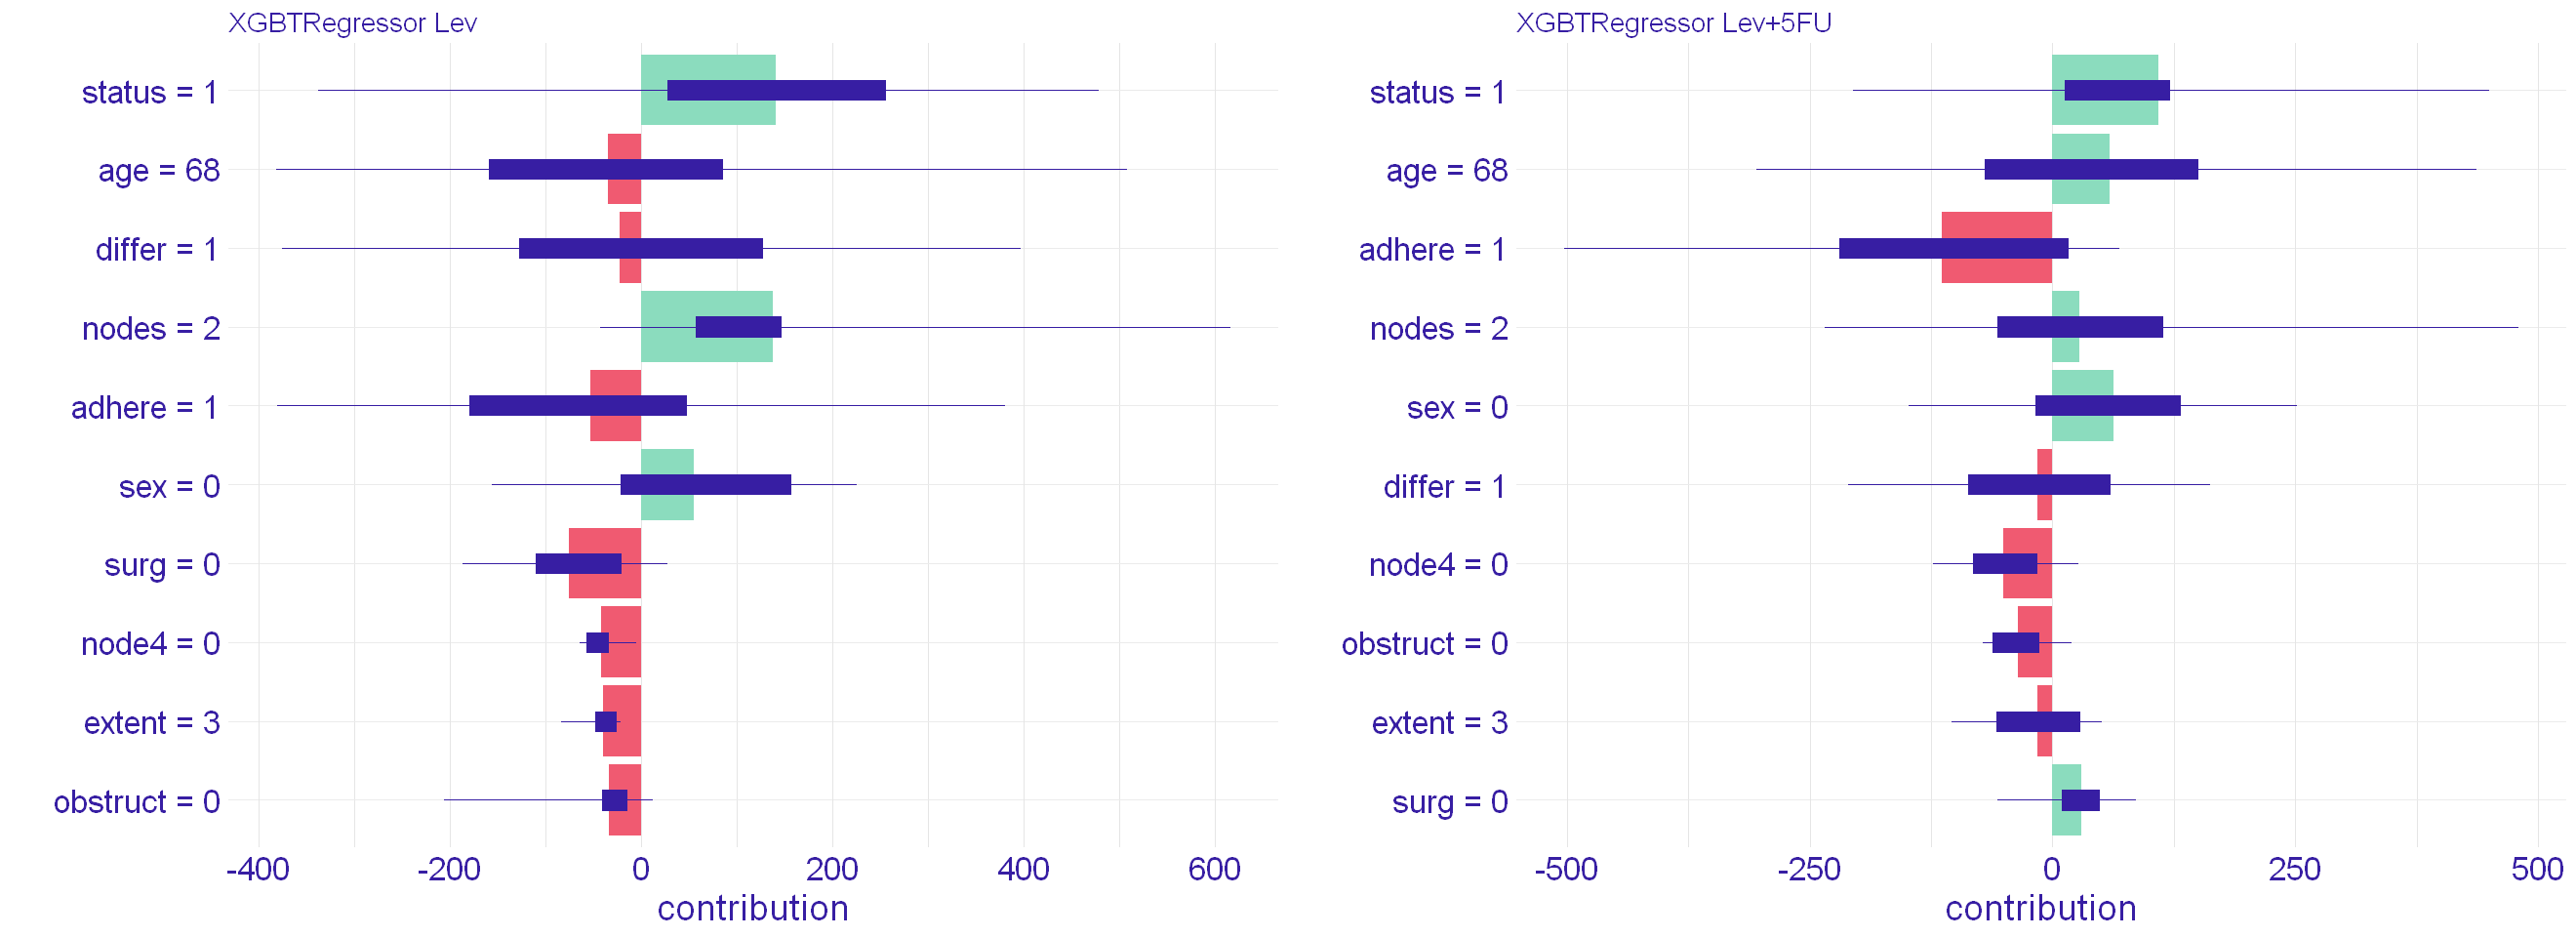

In [12]:
plot_va(va_obs2_Lev, va_obs2_Lev5FU)